In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)

# FOR COLAB FILE UPLOAD
from google.colab import files
print("⬆️ Upload 3 files NOW:")
uploaded = files.upload()


⬆️ Upload 3 files NOW:


Saving olist_orders_dataset.csv to olist_orders_dataset.csv
Saving olist_order_items_dataset.csv to olist_order_items_dataset.csv
Saving olist_order_payments_dataset.csv to olist_order_payments_dataset.csv


In [2]:
orders = pd.read_csv("olist_orders_dataset.csv")
items = pd.read_csv("olist_order_items_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")

print("Orders:", orders.shape)
print("Items:", items.shape)
print("Payments:", payments.shape)

orders.head(), items.head(), payments.head()


Orders: (99441, 8)
Items: (112650, 7)
Payments: (103886, 5)


(                           order_id                       customer_id  \
 0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
 1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
 2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
 3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
 4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
 
   order_status order_purchase_timestamp    order_approved_at  \
 0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
 1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
 2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
 3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
 4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   
 
   order_delivered_carrier_date order_delivered_customer_date  \
 0          2017-10-04 19:55:00           2017-10-10 21:25:13   
 1          2018-07-26 14:31:00 

In [3]:
# Convert order date
orders["order_purchase_timestamp"] = pd.to_datetime(
    orders["order_purchase_timestamp"]
)

# Merge datasets
df = orders.merge(items, on="order_id", how="left")
df = df.merge(payments, on="order_id", how="left")

# Final usable columns
df = df[[
    "customer_id",
    "order_purchase_timestamp",
    "price",
    "freight_value",
    "payment_value"
]]

# Convert order date
df["order_date"] = pd.to_datetime(df["order_purchase_timestamp"])

# Create total order amount
df["order_amount"] = df["payment_value"]

df = df.dropna(subset=["customer_id", "order_date", "order_amount"])

df.head()


,customer_id,order_purchase_timestamp,price,freight_value,payment_value,order_date,order_amount
0,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,29.99,8.72,18.12,2017-10-02 10:56:33,18.12
1,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,29.99,8.72,2.00,2017-10-02 10:56:33,2.00
2,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,29.99,8.72,18.59,2017-10-02 10:56:33,18.59
3,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,118.70,22.76,141.46,2018-07-24 20:41:37,141.46
4,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,159.90,19.22,179.12,2018-08-08 08:38:49,179.12


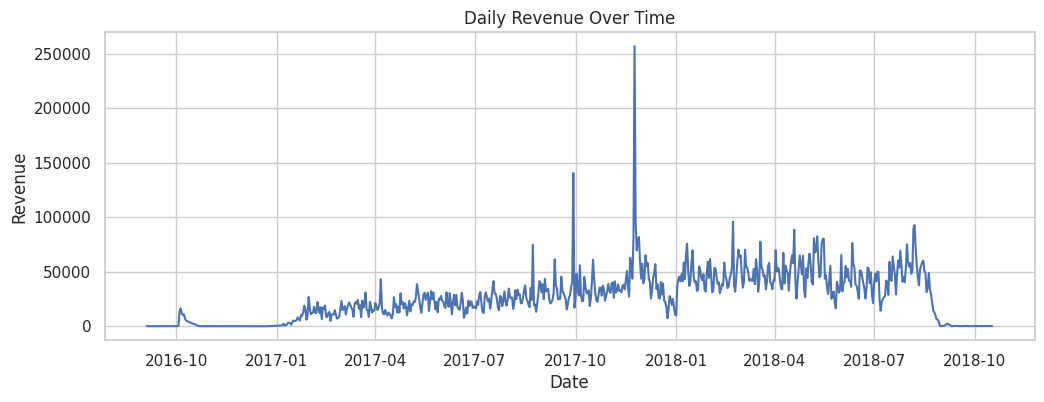

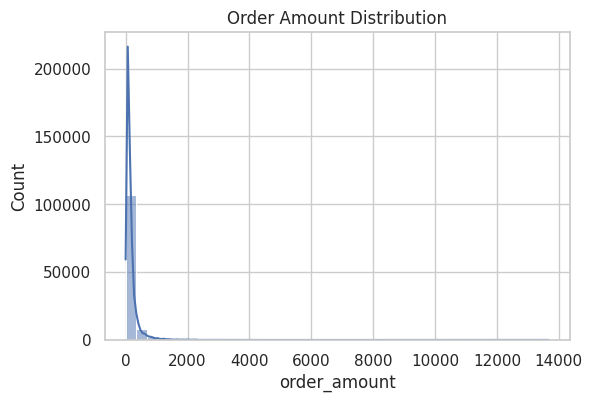

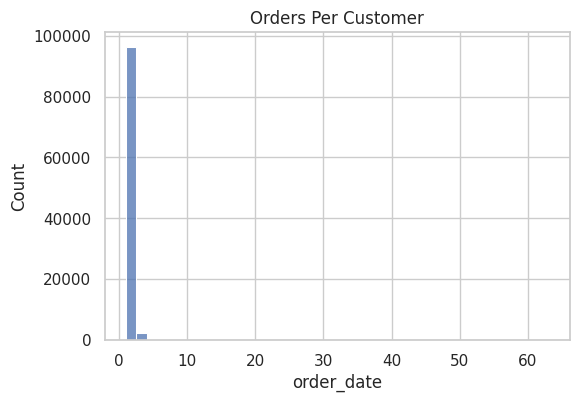

In [4]:
# Plot daily revenue
daily = df.groupby(df["order_date"].dt.date)["order_amount"].sum()

plt.figure(figsize=(12,4))
daily.plot()
plt.title("Daily Revenue Over Time")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show()

# Distribution of order amounts
plt.figure(figsize=(6,4))
sns.histplot(df["order_amount"], bins=40, kde=True)
plt.title("Order Amount Distribution")
plt.show()

# Orders per customer
cust_orders = df.groupby("customer_id")["order_date"].count()

plt.figure(figsize=(6,4))
sns.histplot(cust_orders, bins=40)
plt.title("Orders Per Customer")
plt.show()


In [5]:
snapshot_date = df["order_date"].max() + timedelta(days=1)

customer_df = df.groupby("customer_id").agg(
    frequency=("order_date", "count"),
    recency=("order_date", lambda x: (snapshot_date - x.max()).days),
    first_purchase=("order_date", "min"),
    last_purchase=("order_date", "max"),
    total_revenue=("order_amount", "sum"),
    avg_order_value=("order_amount", "mean"),
    max_order_value=("order_amount", "max"),
    min_order_value=("order_amount", "min")
).reset_index()

customer_df["customer_age_days"] = (
    customer_df["last_purchase"] - customer_df["first_purchase"]
).dt.days + 1

customer_df["clv"] = customer_df["total_revenue"]

customer_df.head()


,customer_id,frequency,recency,first_purchase,last_purchase,total_revenue,avg_order_value,max_order_value,min_order_value,customer_age_days,clv
0,00012a2ce6f8dcda20d059ce98491703,1,338,2017-11-14 16:08:26,2017-11-14 16:08:26,114.74,114.74,114.74,114.74,1,114.74
1,000161a058600d5901f007fab4c27140,1,459,2017-07-16 09:40:32,2017-07-16 09:40:32,67.41,67.41,67.41,67.41,1,67.41
2,0001fd6190edaaf884bcaf3d49edf079,1,597,2017-02-28 11:06:43,2017-02-28 11:06:43,195.42,195.42,195.42,195.42,1,195.42
3,0002414f95344307404f0ace7a26f1d5,1,428,2017-08-16 13:09:20,2017-08-16 13:09:20,179.35,179.35,179.35,179.35,1,179.35
4,000379cdec625522490c315e70c7a9fb,1,199,2018-04-02 13:42:17,2018-04-02 13:42:17,107.01,107.01,107.01,107.01,1,107.01


from matplotlib import pyplot as plt
_df_0['recency'].plot(kind='hist', bins=20, title='recency')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['total_revenue'].plot(kind='hist', bins=20, title='total_revenue')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['avg_order_value'].plot(kind='hist', bins=20, title='avg_order_value')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['max_order_value'].plot(kind='hist', bins=20, title='max_order_value')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('customer_id').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='recency', y='total_revenue', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='total_revenue', y='avg_order_value', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='avg_order_value', y='max_order_value', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='max_order_value', y='min_order_value', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['first_purchase']
  ys = series['recency']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('first_purchase', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('customer_id')):
  _plot_series(series, series_name, i)
  fig.legend(title='customer_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('first_purchase')
_ = plt.ylabel('recency')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['first_purchase']
  ys = series['total_revenue']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('first_purchase', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('customer_id')):
  _plot_series(series, series_name, i)
  fig.legend(title='customer_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('first_purchase')
_ = plt.ylabel('total_revenue')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['first_purchase']
  ys = series['avg_order_value']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('first_purchase', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('customer_id')):
  _plot_series(series, series_name, i)
  fig.legend(title='customer_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('first_purchase')
_ = plt.ylabel('avg_order_value')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['first_purchase']
  ys = series['max_order_value']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('first_purchase', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('customer_id')):
  _plot_series(series, series_name, i)
  fig.legend(title='customer_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('first_purchase')
_ = plt.ylabel('max_order_value')

from matplotlib import pyplot as plt
_df_13['recency'].plot(kind='line', figsize=(8, 4), title='recency')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['total_revenue'].plot(kind='line', figsize=(8, 4), title='total_revenue')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['avg_order_value'].plot(kind='line', figsize=(8, 4), title='avg_order_value')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['max_order_value'].plot(kind='line', figsize=(8, 4), title='max_order_value')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['customer_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='recency', y='customer_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['customer_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='total_revenue', y='customer_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['customer_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='avg_order_value', y='customer_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['customer_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='max_order_value', y='customer_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

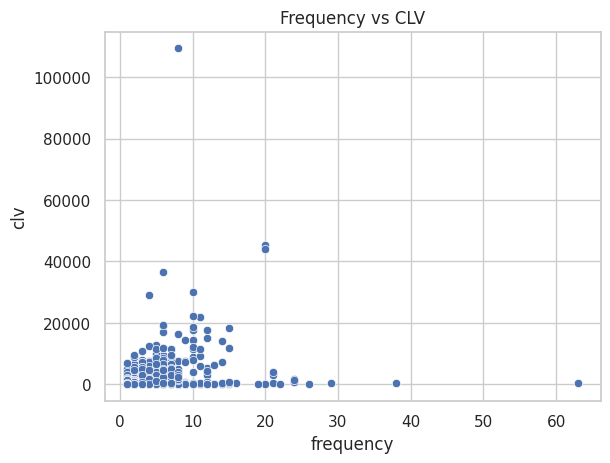

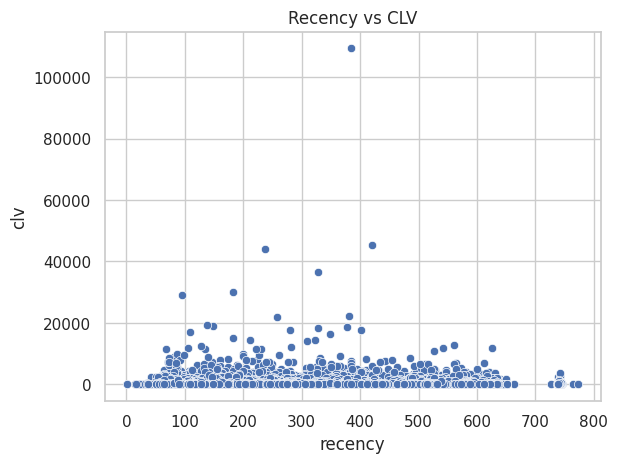

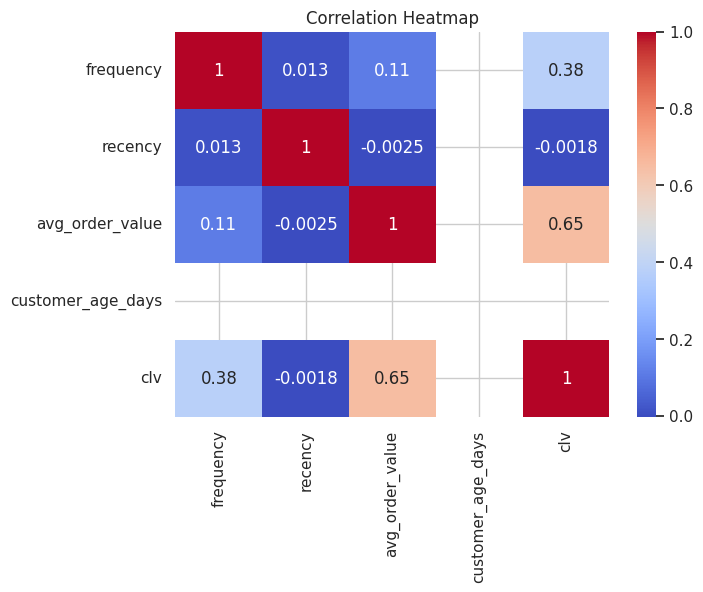

In [6]:
# Scatter PLots
sns.scatterplot(data=customer_df, x="frequency", y="clv")
plt.title("Frequency vs CLV")
plt.show()

sns.scatterplot(data=customer_df, x="recency", y="clv")
plt.title("Recency vs CLV")
plt.show()

# Heatmap
corr = customer_df[["frequency","recency","avg_order_value","customer_age_days","clv"]].corr()

plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [7]:
features = ["frequency","recency","avg_order_value","customer_age_days"]
X = customer_df[features]
y = customer_df["clv"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

model = RandomForestRegressor(n_estimators=400, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))


MAE: 5.320712285046347
RMSE: 568.5087555040969
R²: 0.6246658903227598


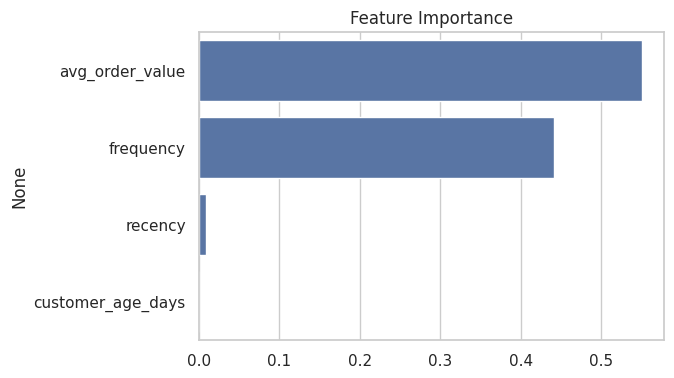

,0
avg_order_value,0.550561
frequency,0.440920
recency,0.008518
customer_age_days,0.000000


In [8]:
imp = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(x=imp.values, y=imp.index)
plt.title("Feature Importance")
plt.show()

imp
